In [ ]:
import numpy as np
import pandas as pd 

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalMaxPooling2D
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.optimizers import RMSprop
from keras import backend

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import random
import os
import zipfile

In [ ]:
print(os.listdir("/kaggle/input/dogs-vs-cats/"))

with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r") as z:
    z.extractall("/kaggle/working/dogs-vs-cats/")
    


['test1.zip', 'train.zip', 'sampleSubmission.csv']


In [ ]:
filenames = os.listdir("/kaggle/working/dogs-vs-cats/train")

df = pd.DataFrame()

df['filename'] = filenames
df['category'] = df['filename'].apply(lambda x: x.split('.')[0])
df['label'] = np.where(df['category'] == 'cat', 0, 1)
df.head(n=10)

,filename,category,label
0,dog.2704.jpg,dog,1
1,dog.988.jpg,dog,1
2,cat.3974.jpg,cat,0
3,cat.11911.jpg,cat,0
4,cat.5837.jpg,cat,0
5,dog.4195.jpg,dog,1
6,dog.4348.jpg,dog,1
7,dog.9632.jpg,dog,1
8,dog.1636.jpg,dog,1
9,cat.9020.jpg,cat,0


cat    12500
dog    12500
Name: category, dtype: int64


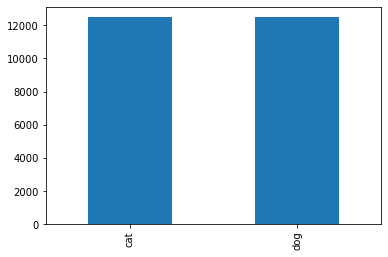

In [ ]:
print(df['category'].value_counts())
df['category'].value_counts().plot.bar()

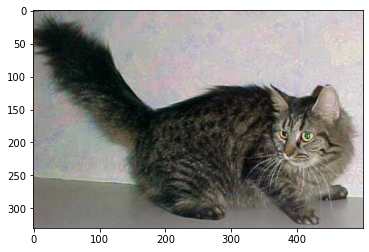

In [ ]:
image = load_img("/kaggle/working/dogs-vs-cats/train/" + random.choice(filenames))
plt.imshow(image)

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5)) #Francois Chollet place drop out after flatten in his book Deep Learning with Python (Ch 5, Page 141)
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

opt = RMSprop(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

In [ ]:
df.head()

,filename,category,label
0,dog.2704.jpg,dog,1
1,dog.988.jpg,dog,1
2,cat.3974.jpg,cat,0
3,cat.11911.jpg,cat,0
4,cat.5837.jpg,cat,0


In [ ]:
train_df, validate_df = train_test_split(df.drop(columns = 'label'), test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
print(train_df['category'].value_counts())
print(train_df.shape)
print('-'*60)
print(validate_df['category'].value_counts())
print(validate_df.shape)

cat    10035
dog     9965
Name: category, dtype: int64
(20000, 2)
------------------------------------------------------------
dog    2535
cat    2465
Name: category, dtype: int64
(5000, 2)


In [ ]:
train_df

,filename,category
0,cat.5935.jpg,cat
1,cat.3914.jpg,cat
2,cat.12144.jpg,cat
3,cat.5817.jpg,cat
4,dog.6384.jpg,dog
...,...,...
19995,dog.5562.jpg,dog
19996,cat.1862.jpg,cat
19997,cat.64.jpg,cat
19998,dog.7480.jpg,dog


In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    zoom_range=0.2,
    #height_shift_range=0.2,
    #width_shift_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/kaggle/working/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=16 
    #images served in each epoch
)

valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    validate_df, 
    "/kaggle/working/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=16 
    #images served in each epoch
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


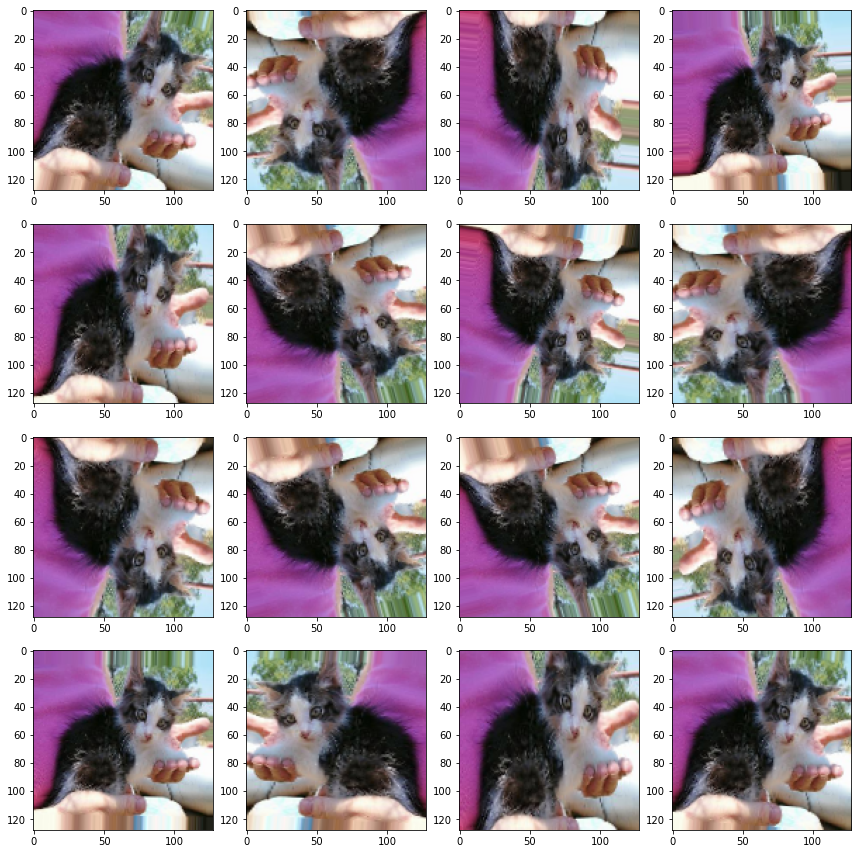

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    zoom_range=0.2,
    #height_shift_range=0.2,
    #width_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
).flow_from_dataframe(
    example_df, 
    "/kaggle/working/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size = 1
)

plt.figure(figsize=(12, 12))
for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    x = example_generator.next()
    image = x[0][0]
    plt.imshow(image)
plt.tight_layout()
plt.show()

In [ ]:
earlystop = EarlyStopping(patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.001)

checkpoint_filepath = '/kaggle/working/catsdogsmodel.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# print the learning rate
class LearningRateMonitor(Callback):
#end of each training epoch
    def on_epoch_end(self, epoch, logs=None):
    # print optimizer learning rate
        optimizer = self.model.optimizer
        print("\nLearning rate: {}".format(backend.get_value(model.optimizer.lr)))

lrm = LearningRateMonitor()

callbacks = [earlystop, model_checkpoint_callback, reduce_lr, lrm]

In [ ]:
if not os.path.isfile(checkpoint_filepath):
    print('Pre-trained weights not found. Training from scratch.')
else:
    model.load_weights(checkpoint_filepath)

epochs = 10
history = model.fit_generator(
    generator = train_generator, 
    epochs=epochs,
    validation_data=valid_generator,
    callbacks = callbacks
)
model.save('/kaggle/working/catsdogsmodel.h5')

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4979
Learning rate: 0.009999999776482582
1250/1250 [==============================] - 135s 108ms/step - loss: 0.6938 - accuracy: 0.4979 - val_loss: 0.6948 - val_accuracy: 0.5070
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4972
Learning rate: 0.009999999776482582
1250/1250 [==============================] - 138s 110ms/step - loss: 0.6939 - accuracy: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4965
Learning rate: 0.009999999776482582
1250/1250 [==============================] - 133s 106ms/step - loss: 0.6939 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 4/10
1250/1250 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4997
Learning rate: 0.009999999776482582
1250/1250 [==============================] - 134s 107

In [ ]:
history.history

{'loss': [0.6937962174415588,
  0.6939491033554077,
  0.6939047574996948,
  0.6937846541404724,
  0.6940523386001587,
  0.6969201564788818,
  0.6938969492912292,
  0.6933331489562988,
  0.6932426691055298],
 'accuracy': [0.4978500008583069,
  0.4972499907016754,
  0.4965499937534332,
  0.4997499883174896,
  0.49424999952316284,
  0.49904999136924744,
  0.49595001339912415,
  0.4995500147342682,
  0.4959999918937683],
 'val_loss': [0.6947858929634094,
  0.6931110620498657,
  0.6930832266807556,
  0.6930726766586304,
  0.6931020617485046,
  0.6950063705444336,
  0.6946653723716736,
  0.6932308077812195,
  0.6931102275848389],
 'val_accuracy': [0.5070000290870667,
  0.5070000290870667,
  0.5070000290870667,
  0.5070000290870667,
  0.5070000290870667,
  0.49300000071525574,
  0.49300000071525574,
  0.49300000071525574,
  0.5070000290870667],
 'lr': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.001, 0.001]}

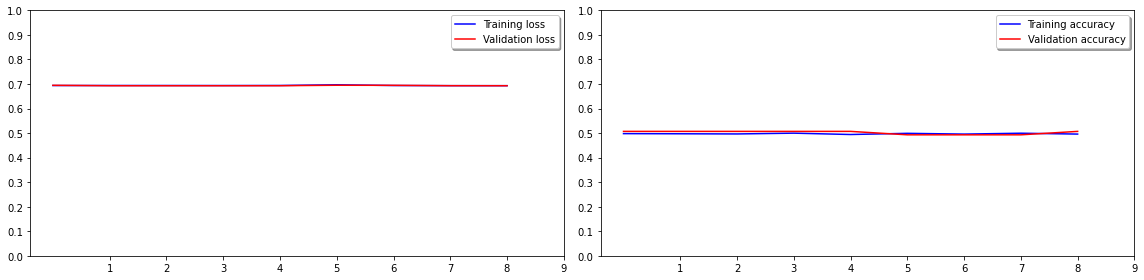

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.set_ylim(0.0,1.0)

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_ylim(0.0,1.0)

ax1.legend(loc='best', shadow=True)
ax2.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
y_prob = model.predict_generator(valid_generator)
y_classes = y_prob.argmax(axis=-1)
print(train_generator.class_indices)
print(y_prob[0])
print(y_classes[0])

labels_map = dict((v,k) for (k,v) in train_generator.class_indices.items())
print(labels_map)

validate_df['pred_class'] = y_classes
validate_df['pred_prob'] = y_prob[:,1]
validate_df['pred_label'] = validate_df['pred_class'].replace(labels_map)
validate_df.head(n=10)

{'cat': 0, 'dog': 1}
[0.4985973  0.50140274]
1
{0: 'cat', 1: 'dog'}


,filename,category,pred_class,pred_prob,pred_label
0,dog.9525.jpg,dog,1,0.501403,dog
1,cat.3211.jpg,cat,1,0.501403,dog
2,dog.11029.jpg,dog,1,0.501403,dog
3,dog.941.jpg,dog,1,0.501403,dog
4,cat.7824.jpg,cat,1,0.501403,dog
5,cat.11010.jpg,cat,1,0.501403,dog
6,dog.1818.jpg,dog,1,0.501403,dog
7,cat.10297.jpg,cat,1,0.501403,dog
8,dog.3117.jpg,dog,1,0.501403,dog
9,dog.4511.jpg,dog,1,0.501403,dog


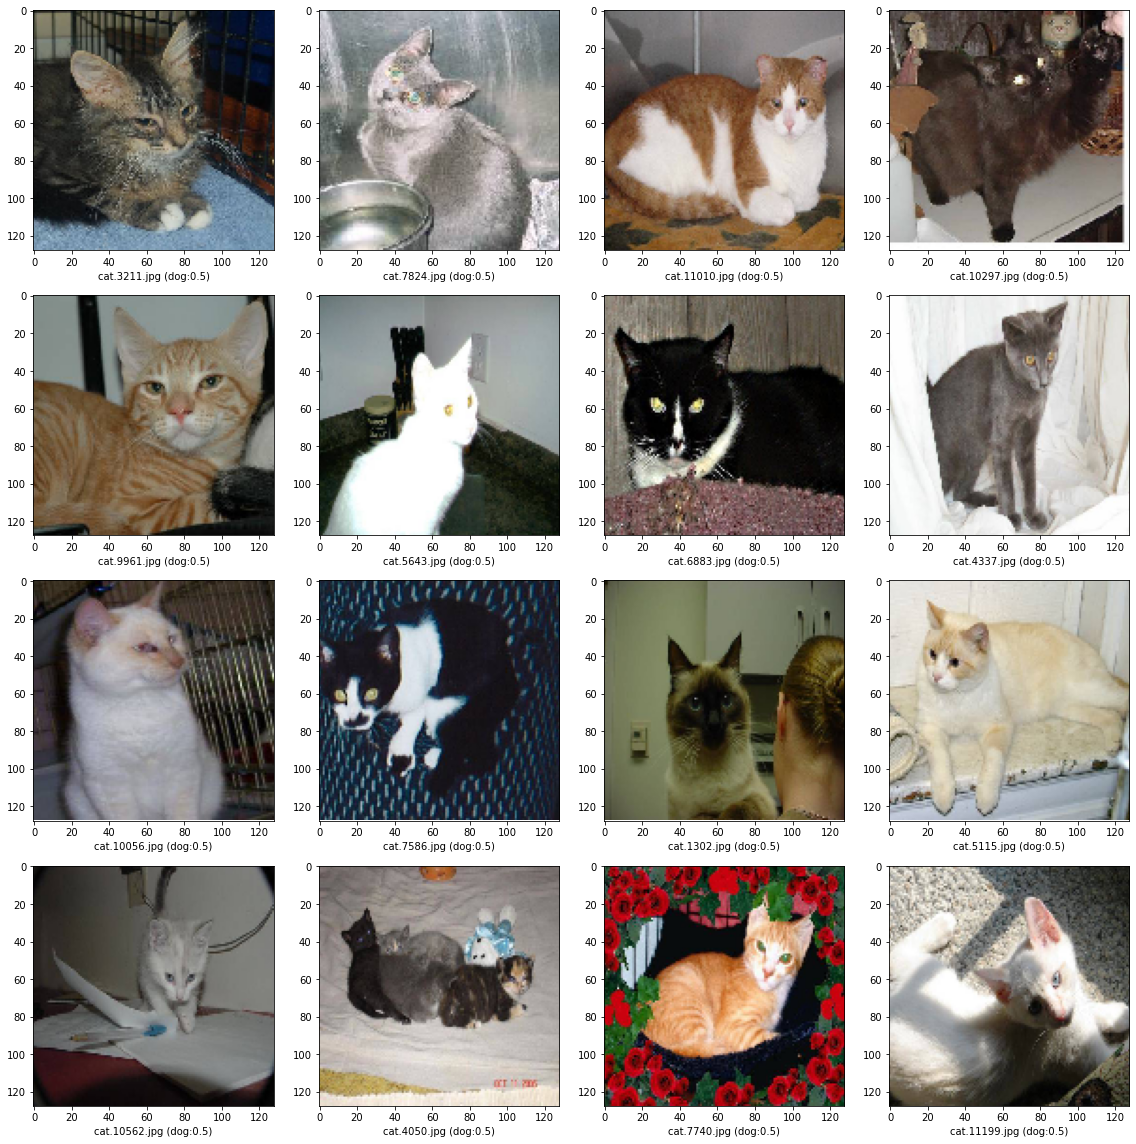

In [ ]:
sample_test = validate_df[validate_df['category'] != validate_df['pred_label']].head(n=16).reset_index(drop=True)
plt.figure(figsize=(16, 16))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['pred_label']
    prob = float(row['pred_prob'])
    img = load_img("/kaggle/working/dogs-vs-cats/train/" + filename, target_size=(128,128))
    plt.subplot(4, 4, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' (' + category + ':' + str(round(prob,2)) + ')' )
plt.tight_layout()
plt.show()